In [21]:
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import pandas as pd
import torch
import os
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.models
import torch.optim as optim
from tqdm import tqdm
import gc
import numpy as np

In [22]:
transformer = Compose([
    Resize((480,480)),
    CenterCrop(480),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

In [23]:
class DinoDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.key_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
    
        img_name = os.path.join(self.root_dir, self.key_frame.iloc[idx,0])
        image = Image.open(img_name)
        image = ToTensor()(image)
        label = torch.tensor(self.key_frame.iloc[idx, 1])

        if self.transform: 
            image = self.transform(image)

        return image, label

In [24]:
key_frame = pd.read_csv("labels_dino.csv")
train,test = train_test_split(key_frame, test_size = 0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
train.sample(10)


,file_name,class
11542,2023_05_09_12_03_18.435221 n.png,0
12070,2023_05_09_12_03_30.949616 n.png,0
6637,2023_05_09_12_00_08.453611 space.png,1
7023,2023_05_09_12_00_17.770756 space.png,1
10815,2023_05_09_12_03_00.833050 n.png,0
11587,2023_05_09_12_03_19.499662 n.png,0
7908,2023_05_09_12_00_40.269449 n.png,0
8467,2023_05_09_12_00_53.685727 n.png,0
5196,2023_05_09_10_48_36.075201 n.png,0
7612,2023_05_09_12_00_32.719418 n.png,0


In [25]:
batch_size = 8
trainset = DinoDataset(root_dir = "captures", dataframe = train, transform = transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True) 

testset = DinoDataset(root_dir = "captures", dataframe = test, transform = transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [26]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


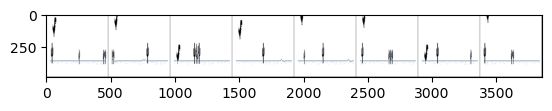

0 0 0 0 0 0 0 0


In [27]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.efficientnet_v2_s()
model.classifier = torch.nn.Linear(in_features = 1280, out_features = 2)
model = model.to(device)


criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.009)

# Training

In [29]:
epochs =15
loss_container = []
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in tqdm(trainloader, position = 0, leave = True ):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    loss_container.append(running_loss)

    print(f'[{epoch + 1}] | loss: {running_loss / len(trainloader):.3f}')
    running_loss = 0.0

print('Finished Training')

100%|██████████| 1280/1280 [05:35<00:00,  3.82it/s]


[1] | loss: 0.365


100%|██████████| 1280/1280 [05:20<00:00,  4.00it/s]


[2] | loss: 0.238


100%|██████████| 1280/1280 [05:15<00:00,  4.06it/s]


[3] | loss: 0.203


100%|██████████| 1280/1280 [05:55<00:00,  3.60it/s]


[4] | loss: 0.198


100%|██████████| 1280/1280 [05:45<00:00,  3.70it/s]


[5] | loss: 0.182


100%|██████████| 1280/1280 [05:25<00:00,  3.93it/s]


[6] | loss: 0.176


100%|██████████| 1280/1280 [05:40<00:00,  3.76it/s]


[7] | loss: 0.172


100%|██████████| 1280/1280 [05:47<00:00,  3.68it/s]


[8] | loss: 0.166


100%|██████████| 1280/1280 [06:47<00:00,  3.14it/s]


[9] | loss: 0.168


100%|██████████| 1280/1280 [05:51<00:00,  3.64it/s]


[10] | loss: 0.161


100%|██████████| 1280/1280 [05:11<00:00,  4.10it/s]


[11] | loss: 0.162


100%|██████████| 1280/1280 [04:58<00:00,  4.29it/s]


[12] | loss: 0.156


100%|██████████| 1280/1280 [05:14<00:00,  4.07it/s]


[13] | loss: 0.152


100%|██████████| 1280/1280 [05:24<00:00,  3.94it/s]


[14] | loss: 0.151


100%|██████████| 1280/1280 [05:30<00:00,  3.88it/s]

[15] | loss: 0.147
Finished Training


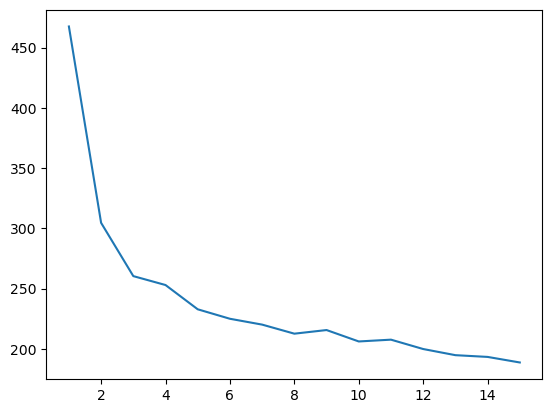

In [32]:
# loss_container
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_container)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# Save Model Weights

In [ ]:
PATH = 'efficientnet_s.pth'
torch.save(model.state_dict(), PATH)

# Test and Inference

In [ ]:
saved_model = torchvision.models.efficientnet_v2_s()
saved_model.classifier = torch.nn.Linear(in_features = 1280, out_features = 2)
saved_model.load_state_dict(torch.load(PATH))
saved_model = saved_model.to(device)
saved_mode = saved_model.eval()



In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(trainloader, position = 0, leave = True):
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = saved_model(images)
    predicted = torch.softmax(outputs,dim = 1).argmax(dim = 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()



100%|██████████| 642/642 [00:52<00:00, 12.28it/s]


 Accuracy of the network on the training images: 89 %


In [ ]:
print(f'\n Accuracy of the network on the training images: {100 * correct // total} %')


 Accuracy of the network on the training images: 87 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(testloader):
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = saved_model(images)
    predicted = torch.softmax(outputs,dim = 1).argmax(dim = 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


100%|██████████| 161/161 [00:13<00:00, 12.30it/s]


 Accuracy of the network on the test images: 87 %


In [ ]:
print(f'\n Accuracy of the network on the test images: {100 * correct // total} %')


 Accuracy of the network on the test images: 87 %
